### Notebook to plot diurnal composites from BOWTIE sounding data.

James Ruppert  
jruppert@ou.edu  
8/19/24

### Main settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import subprocess, cmocean
import xarray as xr
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from time_series_diag import *
from bowtie_read_data import *

In [2]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

### Compute diagnostics

In [3]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

In [4]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
dse = cp*snd_asc['tmpk'] + g*hght[np.newaxis,:]
lvq= lv*snd_asc['mr']
mse = dse + lvq

# Static stability
theta = theta_dry(snd_asc['tmpk'], snd_asc['p'])
def smooth_theta(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(invar_pd))
for ido in range(3):
    theta = smooth_theta(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
# for ido in range(10):
dthdz = smooth_theta(dthdz, nz_smooth=20)

tmpk_ddz = np.copy(snd_asc['tmpk'])
for ido in range(3):
    tmpk_ddz = smooth_theta(tmpk_ddz, nz_smooth=10)
dtdz = np.gradient(tmpk_ddz, hght, axis=1) # K/m
dtdz = smooth_theta(dtdz, nz_smooth=20)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_36028/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_36028/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_36028/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/

---
### Plotting routines

#### Plot functions

In [5]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [6]:
# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth(invar, nt_smooth=8, nz_smooth=10):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    # var_trns = var_sm1.transpose()
    # var_sm = var_trns.rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # var_sm = var_sm1.transpose()
    # return np.squeeze(np.array(var_sm.transpose()))
    return np.squeeze(np.array(var_sm1))
# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth_2d(invar, nt_smooth=8):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm))

In [7]:
# Calculate diurnal composite
def diurnal_composite(invar, npd, anom=False):

    # Remove daily mean using running mean
    if anom:
        invar_pd = pd.DataFrame(invar)
        var_dm = invar_pd.rolling(axis=0,window=8, center=True, closed='both', min_periods=3).mean()
        var_dm = np.array(var_dm)
        invar -= var_dm

    nd = int(invar.shape[0]/npd)
    dc_indices=np.arange(nd)*npd
    nz=invar.shape[1]
    dims=(npd, nz)
    var_dc=np.full(dims, np.nan)

    for ihour in range(npd):
        var_dc[ihour,:] = np.nanmean(invar[dc_indices+ihour,:], axis=0)
    # var_dc[npd,:] = var_dc[0,:]

    # Repeat diurnal cycle in time
    var_dc = np.concatenate((var_dc, var_dc, var_dc[0:1,:]), axis=0)

    return var_dc

In [8]:
def plot_dc_time_height(figdata):

    npd=figdata['npd']
    var_dc = diurnal_composite(figdata['pltvar'], npd, anom=figdata['anom'])

    fig_x = 6
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ax.set_ylim(0,16)#12)
    # ax.set_ylim(10,22)#12)
    ax.set_xlim(0,48)
    plt.xticks(np.arange(0,49,6))

    ax.grid(True, axis='x', color='0.55', linewidth=0.5)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5)#, which='both')

    # Plot variable
    # xdim=np.arange(npd+1)*24/npd
    xdim=np.arange(npd*2+1)*24/npd
    # im = axs[iax].pcolormesh(xdim, hght, pltvar, cmap=figdata['cmap'], norm=figdata['norm'])
    im = ax.contourf(xdim, hght*1e-3, var_dc.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'])#, norm=figdata['norm'])
    fig.colorbar(im, ax=ax, label=figdata['units'])#, shrink=0.6)

    # Line contours
    im = ax.contour(xdim, hght*1e-3, var_dc.transpose(), figdata['clevels_line'],
                    colors=figdata['clevels_line_color'],linewidths=0.6)

    ax.axvline(x=24, color='black')

    # Time labels
    ax.set_xlabel('Hour [UTC]')

    plt.show()
    plt.close()
    return

#### Case selection

In [12]:
xlim=[np.datetime64('2024-08-17T00:00'), np.datetime64('2024-09-15T23:00')]
# xlim=[np.datetime64('2024-08-19T00:00'), np.datetime64('2024-08-24T00:00')]
# xlim=[np.datetime64('2024-08-19T00:00'), np.datetime64('2024-08-27T00:00')]
# xlim=[np.datetime64('2024-08-26T00:00'), np.datetime64('2024-08-27T00:00')]
# xlim=[np.datetime64('2024-08-25T00:00'), np.datetime64('2024-08-26T00:00')]
xlim=[np.datetime64('2024-08-28T00:00'), np.datetime64('2024-09-07T23:00')]
composite_indices = np.where((times_asc >= xlim[0]) & (times_asc < xlim[1]))[0]

npd=8

#### Thermodynamic variables

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_36028/2631260195.py:7: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  var_dm = invar_pd.rolling(axis=0,window=8, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_36028/2631260195.py:18: RuntimeWarning: Mean of empty slice
  var_dc[ihour,:] = np.nanmean(invar[dc_indices+ihour,:], axis=0)


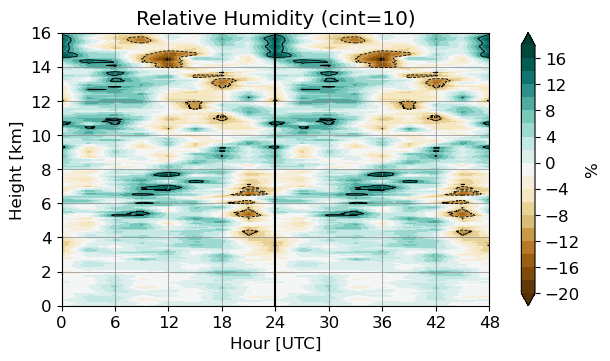

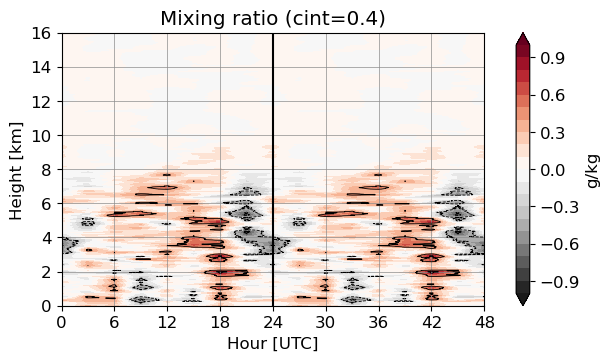

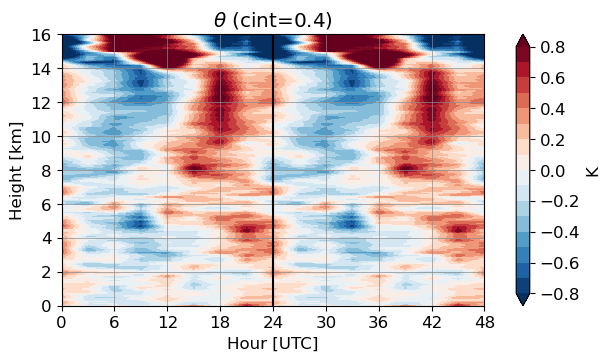

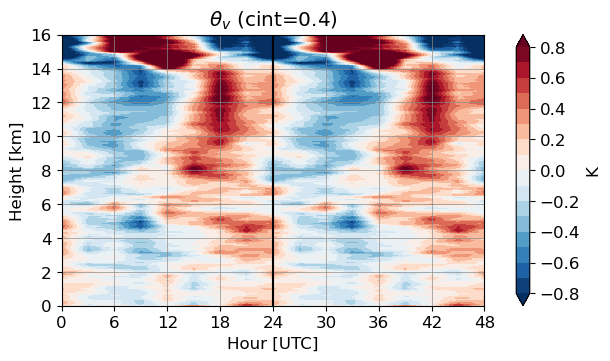

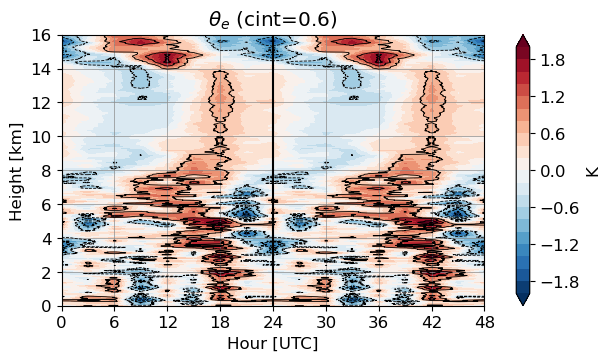

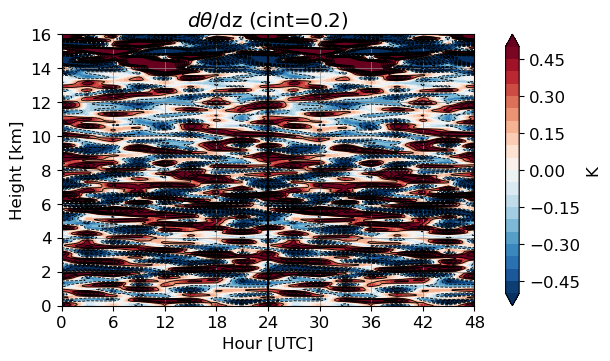

In [13]:
# Relative humidity

cint_lines = 10
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

# figdata = {
#     'pltvar': snd_asc['rh'][composite_indices],
#     'anom': True,
#     'npd': npd,
#     'fig_title': r'Relative Humidity (cint='+str(cint_lines)+')',
#     'units': '%',
#     'cmap': 'BrBG',
#     # 'clevels': np.arange(0,105,5),
#     'clevels': np.arange(-20,20,2),
#     'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
#     'clevels_line_color': 'black',
#     'extend': 'both',
#            }

# plot_dc_time_height(figdata)

# Relative humidity

rh_asc = calc_relh(snd_asc['mr'], snd_asc['p'], snd_asc['tmpk'], ice=True)

figdata = {
    # 'pltvar': snd_asc['rh'],
    'pltvar': rh_asc[composite_indices],
    'anom': True,
    'npd': npd,
    'fig_title': r'Relative Humidity (cint='+str(cint_lines)+')',
    'units': '%',
    'cmap': 'BrBG',
    # 'clevels': np.arange(0,105,5),
    'clevels': np.arange(-20,20,2),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)


# Mixing ratio

cint_lines = .4
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

mr_asc = np.copy(snd_asc['mr'])*1e3

figdata = {
    'pltvar': mr_asc[composite_indices],
    'anom': True,
    'npd': npd,
    'fig_title': 'Mixing ratio (cint='+str(cint_lines)+')',
    'units': 'g/kg',
    'cmap': 'RdGy_r',
    # 'clevels': np.arange(-1.5,1.7,.2),
    'clevels': np.arange(-1.,1.1,.1),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)


# # Temperature

# cint_lines = .4
# contours = np.arange(cint_lines,cint_lines*10,cint_lines)

# t_asc = np.copy(snd_asc['tmpk'])
# # t_asc -= (np.nanmean(t_asc, axis=0))[np.newaxis,:]

# figdata = {
#     'pltvar': t_asc[composite_indices],
#     'anom': True,
#     'npd': npd,
#     'fig_title': 'Temperature (cint='+str(cint_lines)+')',
#     'units': 'K',
#     'cmap': 'RdBu_r',
#     # 'clevels': np.arange(-1.5,1.7,.2),
#     'clevels': np.arange(-0.8,.9,.1),
#     'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
#     'clevels_line_color': 'black',
#     'extend': 'both',
#            }

# plot_dc_time_height(figdata)

# Potential temperature

cint_lines = .4
contours = np.arange(cint_lines,cint_lines*10,cint_lines)
cint_lines = .4
contours = np.arange(290,360,cint_lines)

thv_asc = theta_dry(snd_asc['tmpk'], snd_asc['p'])

figdata = {
    'pltvar': thv_asc[composite_indices],
    'anom': True,
    # 'anom': False,
    'npd': npd,
    'fig_title': r'$\theta$ (cint='+str(cint_lines)+')',
    'units': 'K',
    'cmap': 'RdBu_r',
    # 'clevels': np.arange(-1.5,1.7,.2),
    'clevels': np.arange(-0.8,.9,.1),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    # 'clevels': np.arange(302,312,.2),
    # 'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)

# Virtual potential temperature

cint_lines = .4
contours = np.arange(cint_lines,cint_lines*10,cint_lines)
cint_lines = .4
contours = np.arange(290,360,cint_lines)

thv_asc = theta_virtual(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'])

figdata = {
    'pltvar': thv_asc[composite_indices],
    'anom': True,
    # 'anom': False,
    'npd': npd,
    'fig_title': r'$\theta_v$ (cint='+str(cint_lines)+')',
    'units': 'K',
    'cmap': 'RdBu_r',
    'clevels': np.arange(-0.8,.9,.1),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    # 'clevels': np.arange(302,312,.2),
    # 'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)

# Equivalent potential temperature

cint_lines = .6
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

th_e_asc = theta_equiv(snd_asc['tmpk'], snd_asc['mr'], snd_asc['mr'], snd_asc['p'])

figdata = {
    'pltvar': th_e_asc[composite_indices],
    'anom': True,
    'npd': npd,
    'fig_title': r'$\theta_e$ (cint='+str(cint_lines)+')',
    'units': 'K',
    'cmap': 'RdBu_r',
    'clevels': np.arange(-2,2.2,.2),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)

# Dthdz

cint_lines = .2
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

figdata = {
    'pltvar': dthdz[composite_indices]*1e3, # K/km
    'anom': True,
    'npd': npd,
    'fig_title': r'$d\theta$/dz (cint='+str(cint_lines)+')',
    'units': 'K',
    'cmap': 'RdBu_r',
    'clevels': np.arange(-0.5,0.55,.05),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)

#### Winds

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_36028/2631260195.py:7: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  var_dm = invar_pd.rolling(axis=0,window=8, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_36028/2631260195.py:18: RuntimeWarning: Mean of empty slice
  var_dc[ihour,:] = np.nanmean(invar[dc_indices+ihour,:], axis=0)


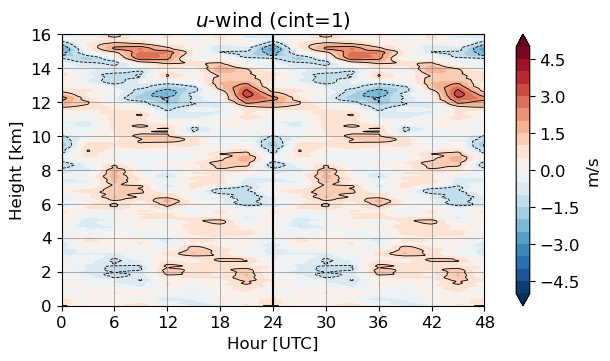

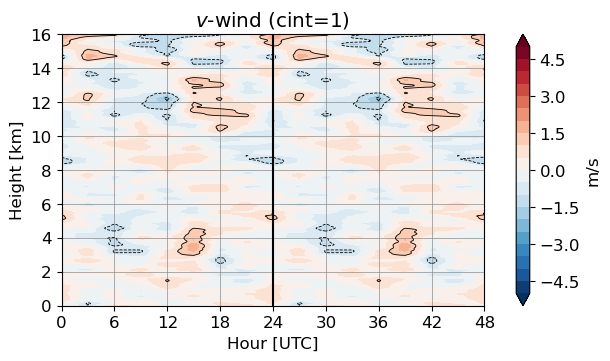

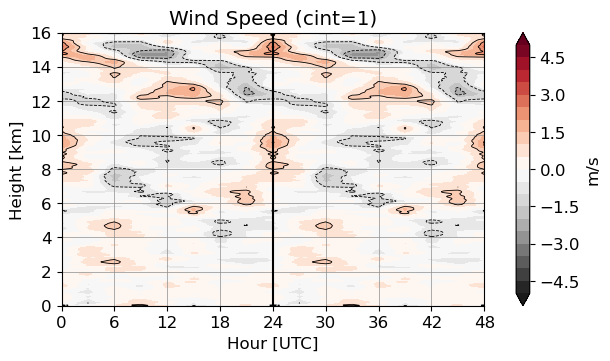

In [14]:
# Winds

cint_lines = 1
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

figdata = {
    'pltvar': snd_asc['u'][composite_indices],
    'anom': True,
    # 'anom': False,
    'npd': npd,
    'fig_title': r'$u$-wind (cint='+str(cint_lines)+')',
    'units': 'm/s',
    'cmap': 'RdBu_r',
    'clevels': np.arange(-5,5.5,0.5),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)

figdata = {
    'pltvar': snd_asc['v'][composite_indices],
    'anom': True,
    # 'anom': False,
    'npd': npd,
    'fig_title': r'$v$-wind (cint='+str(cint_lines)+')',
    'units': 'm/s',
    'cmap': 'RdBu_r',
    'clevels': np.arange(-5,5.5,0.5),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)

cint_lines = 1
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

figdata = {
    'pltvar': np.sqrt(snd_asc['u']**2 + snd_asc['v']**2)[composite_indices],
    'anom': True,
    # 'anom': False,
    'npd': npd,
    'fig_title': 'Wind Speed (cint='+str(cint_lines)+')',
    'units': 'm/s',
    'cmap': 'RdGy_r',
    'clevels': np.arange(-5,5.5,0.5),
    'clevels_line': np.concatenate(( -1*np.flip(contours), contours)),
    'clevels_line_color': 'black',
    'extend': 'both',
           }

plot_dc_time_height(figdata)